In [1]:
from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path, process_images, tokenizer_image_token
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN, IGNORE_INDEX
from llava.conversation import conv_templates, SeparatorStyle

from PIL import Image
import requests
import copy
import torch

/home/tobi/miniconda3/envs/assba/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [2]:
pretrained = "../../models/multimodal/llama3-llava-next-8b"
model_name = "llava_llama3"
device = "cuda"
device_map = "auto"
tokenizer, model, image_processor, max_length = load_pretrained_model(pretrained, None, model_name, device_map=device_map) # Add any other thing you want to pass in llava_model_args

model.eval()
model.tie_weights()

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.
/home/tobi/miniconda3/envs/assba/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/home/tobi/miniconda3/envs/assba/lib/python3.11/site-packages/torch/nn/modules/module.py:2025: UserWarning: for vision_model.embeddings.class_embedding: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign 

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
# with image

In [4]:
url = "https://github.com/haotian-liu/LLaVA/blob/1a91fc274d7c35a9b50b3cb29c4247ae5837ce39/images/llava_v1_5_radar.jpg?raw=true"
image = Image.open(requests.get(url, stream=True).raw)
image_tensor = process_images([image], image_processor, model.config)
image_tensor = [_image.to(dtype=torch.float16, device=device) for _image in image_tensor]

conv_template = "llava_llama_3" # Make sure you use correct chat template for different models
question = DEFAULT_IMAGE_TOKEN + "\nWhat is shown in this image?"
conv = copy.deepcopy(conv_templates[conv_template])
conv.append_message(conv.roles[0], question)
conv.append_message(conv.roles[1], None)
prompt_question = conv.get_prompt()

input_ids = tokenizer_image_token(prompt_question, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(0).to(device)
image_sizes = [image.size]

In [11]:
print(image_tensor[0].shape)

torch.Size([5, 3, 336, 336])


In [15]:
from IPython.display import display
import torchvision

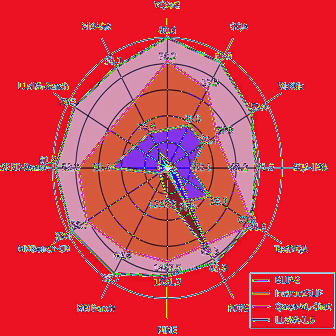

In [22]:
display(torchvision.transforms.functional.to_pil_image(image_tensor[0][0]))

In [5]:
%%time
cont = model.generate(
    input_ids,
    images=image_tensor,
    image_sizes=image_sizes,
    do_sample=False,
    temperature=0,
    max_new_tokens=256,
)
text_outputs = tokenizer.batch_decode(cont, skip_special_tokens=True)
print(text_outputs)

/home/tobi/miniconda3/envs/assba/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


['\nThe image shows a radar chart, also known as a spider chart or a web chart, which is a type of graph used to display multivariate data in the form of a two-dimensional chart of three or more quantitative variables represented on axes starting from the same point. Each axis represents a different variable, and the values are plotted along each axis and connected to form a polygon.\n\nIn this particular radar chart, there are several axes labeled with different variables, such as "MM-Vet," "LLaVA-Bench," "SEED-Bench," "MMBench-CN," "MMBench," "TextVQA," "VizWiz," "GQA," "BLIP-2," "InstructBLIP," "Owen-VL-Chat," and "LLaVA-1.5." These labels suggest that the chart is comparing the performance of different models or systems across various benchmarks or tasks, such as machine translation, visual question answering, and text-based question answering.\n\nThe chart is color-coded, with each color representing a different model or system. The points on the chart are connected to form a poly

In [6]:
# without image

In [9]:
conv_template = "llava_llama_3" # Make sure you use correct chat template for different models
question = "\nWhat is shown in this image?"
conv = copy.deepcopy(conv_templates[conv_template])
conv.append_message(conv.roles[0], question)
conv.append_message(conv.roles[1], None)
prompt_question = conv.get_prompt()

input_ids = tokenizer_image_token(prompt_question, tokenizer, return_tensors="pt").unsqueeze(0).to(device)

In [10]:
%%time
cont = model.generate(
    input_ids,
    do_sample=False,
    temperature=0,
    max_new_tokens=256,
)
text_outputs = tokenizer.batch_decode(cont, skip_special_tokens=True)
print(text_outputs)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


["\nI'm sorry, but I am unable to see the image you are referring to. Can you please provide more information or context about the image you are asking about?"]
CPU times: user 846 ms, sys: 3.98 ms, total: 850 ms
Wall time: 849 ms
